### Preprocessing scRNA-Seq data of fetal monkey ovary (Zhao et al., 2020)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import anndata



def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '/home/jovyan/Prove/Gonads/Monkey_Zhao/figures/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.5.1 anndata==0.7.1 umap==0.4.0 numpy==1.18.1 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.1


'/home/jovyan/my-conda-envs/celloracle_env/bin/python'

#### Load data downloaded from GEO

In [2]:
adata = sc.read('/nfs/team292/vl6/Monkey_Zhao/GSE149629_Count_matrix.txt.gz', cache=True)
adata

... reading from cache file cache/nfs-team292-vl6-Monkey_Zhao-GSE149629_Count_matrix.h5ad


AnnData object with n_obs × n_vars = 18446 × 20967 

In [3]:
# Matrix needs to be transposed 
adata = adata.transpose()

In [4]:
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 20967 × 18446 

**Add metadata**

In [6]:
# If the barcode ends with 1 assign in to first individual, if it ends with 2 assign it to second individual 
adata.obs['stage'] = ['E84' if i.endswith('_1') else 'E116' for i in adata.obs.index]
adata.obs['stage'].value_counts(dropna = False)

E84     10621
E116    10346
Name: stage, dtype: int64

In [7]:
ensembls = []
gene_names = []
for i in adata.var.index:
    if i.startswith('ENSMFAG') == True:
        ensembls.append(i)
    else:
        gene_names.append(i)
print('{} ENSEMBL IDs'.format(len(ensembls)))
print('{} GENE NAMES'.format(len(gene_names)))

3213 ENSEMBL IDs
15233 GENE NAMES


**Convert monkey gene names to human**

In [8]:
# Convert gene names to human going through ENSEMBL 
table = pd.read_csv('/nfs/team292/vl6/Monkey_Zhao/mart_export_monkey.txt', sep = '\t')
print(table.shape)
print(table.columns.values)
#table.head()

(23807, 6)
['Gene stable ID' 'Gene stable ID version' 'Gene name' 'Gene stable ID.1'
 'Gene stable ID version.1' 'Gene name.1']


In [9]:
table = table.dropna()
table = table.drop_duplicates(['Gene stable ID'])
table = table.drop_duplicates(['Gene name'])
table = table.drop_duplicates(['Gene stable ID version'])
table = table.drop_duplicates(['Gene stable ID.1'])
table = table.drop_duplicates(['Gene stable ID version.1'])
table = table.drop_duplicates(['Gene name.1'])
table.shape

(16972, 6)

**Convert monkey gene names to human orthologs**

In [10]:
table_copy = table 
table_copy = table_copy[table_copy['Gene name.1'].isin(gene_names)]
table_copy = table_copy.set_index('Gene name.1')
gene_mapping_1 = table_copy['Gene stable ID.1'].to_dict() # monkey gene name to mouse ENSEMBL

In [11]:
# Add a new column that has only Monkey ENSEMBL IDs 
monkey_ensembl = []
for i in adata.var.index:
    if i.startswith('ENSMFAG') == True:
        monkey_ensembl.append(i)
    else:
        if i in gene_mapping_1:
            monkey_ensembl.append(gene_mapping_1[i])
        else:
            monkey_ensembl.append('delete_gene')

In [12]:
adata.var['monkey_ENSEMBL'] = monkey_ensembl
#adata.var

In [13]:
adata = adata[:, adata.var.monkey_ENSEMBL != 'delete_gene']
adata

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 20967 × 18101 
    obs: 'stage'
    var: 'monkey_ENSEMBL'

In [14]:
table_copy2 = table 
var_names = adata.var.monkey_ENSEMBL.to_list()
table_copy2 = table_copy2[table_copy2['Gene stable ID.1'].isin(var_names)]
gene_mapping_2 = pd.Series(table_copy2['Gene stable ID'].values, index=table_copy2['Gene stable ID.1']).to_dict() # monkey ENSEMBL to human ENSEMBL
adata.var['human_ENSEMBL'] = adata.var['monkey_ENSEMBL'].map(gene_mapping_2)

Trying to set attribute `.var` of view, copying.


In [15]:
# Convert to string and remove NaN
adata.var['human_ENSEMBL'] = adata.var['human_ENSEMBL'].astype(str)
adata = adata[:, adata.var.human_ENSEMBL != 'nan']
adata.var.head(10)

,monkey_ENSEMBL,human_ENSEMBL
PGBD2,ENSMFAG00000044637,ENSG00000185220
ZNF692,ENSMFAG00000039056,ENSG00000171163
ZNF672,ENSMFAG00000030010,ENSG00000171161
SH3BP5L,ENSMFAG00000002737,ENSG00000175137
OR2M4,ENSMFAG00000021769,ENSG00000171180
ENSMFAG00000010782,ENSMFAG00000010782,ENSG00000203663
OR2AJ1,ENSMFAG00000039872,ENSG00000177275
TRIM58,ENSMFAG00000032683,ENSG00000162722
GCSAML,ENSMFAG00000041250,ENSG00000169224
NLRP3,ENSMFAG00000038424,ENSG00000162711


In [16]:
adata

View of AnnData object with n_obs × n_vars = 20967 × 15080 
    obs: 'stage'
    var: 'monkey_ENSEMBL', 'human_ENSEMBL'

In [17]:
gene_mapping_3 = pd.Series(table_copy2['Gene name'].values,index=table_copy2['Gene stable ID']).to_dict() # human ENSEMBL to human gene name
adata.var['human_gene_name'] = adata.var['human_ENSEMBL'].map(gene_mapping_3)
#adata.var.head(10)

Trying to set attribute `.var` of view, copying.


In [18]:
# Set human gene name as default var names 
adata.var['monkey_gene_name'] = adata.var_names
adata.var_names = adata.var['human_gene_name']
adata.var.rename(columns={'human_gene_name': 'human_gene_ortholog'}, inplace=True)
#adata.var.head(10)

#### Start the analysis from here

In [19]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
len(mito_genes)

13

In [20]:
adata.var_names_make_unique()

In [21]:
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,stage,percent_mito
AAACCCAAGCTTTCCC_1,E84,0.246575
AAACCCAAGTCAGCCC_1,E84,0.176325
AAACCCAAGTGCTACT_1,E84,0.124555
AAACCCACAGCGCGTT_1,E84,0.165124
AAACCCAGTGACACAG_1,E84,0.176623
...,...,...
TTTGTTGTCATTATCC_2,E116,0.174961
TTTGTTGTCGGCTGAC_2,E116,0.901862
TTTGTTGTCGGTAGAG_2,E116,0.192670
TTTGTTGTCTACTCAT_2,E116,0.081050


In [22]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
#adata.obs

In [23]:
sc.pp.filter_cells(adata, min_genes = 300)
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 980 cells that have less than 300 genes expressed


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 2 genes that are detected in less than 3 cells


In [24]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['stage'].value_counts()

Total number of cells: 19987
Total number of genes: 15078


E84     10226
E116     9761
Name: stage, dtype: int64

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1154: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'stage' as categorical
... storing 'monkey_ENSEMBL' as categorical
... storing 'human_ENSEMBL' as categorical


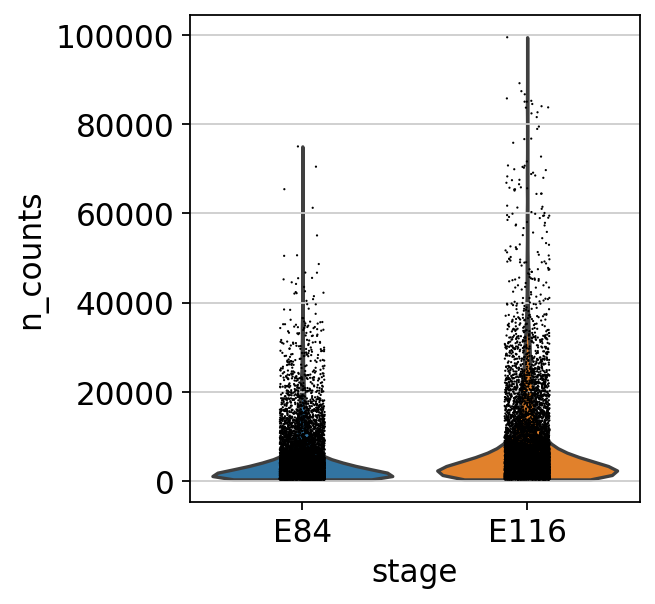

In [25]:
sc.pl.violin(adata, keys = ['n_counts'], groupby = 'stage')

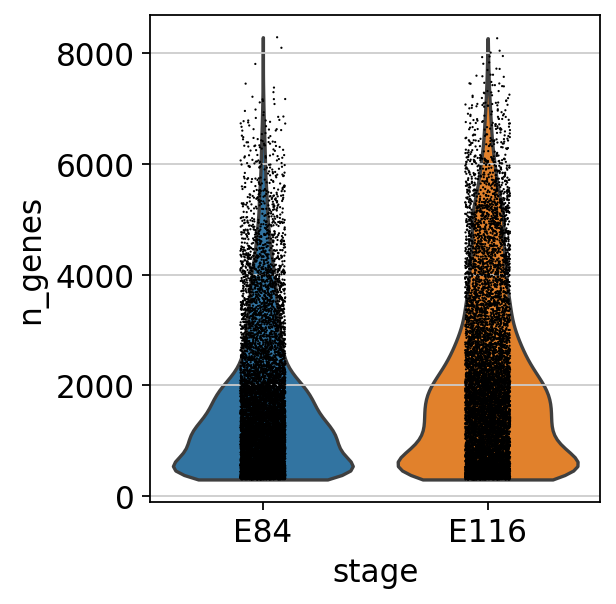

In [26]:
sc.pl.violin(adata, keys = ['n_genes'], groupby = 'stage')

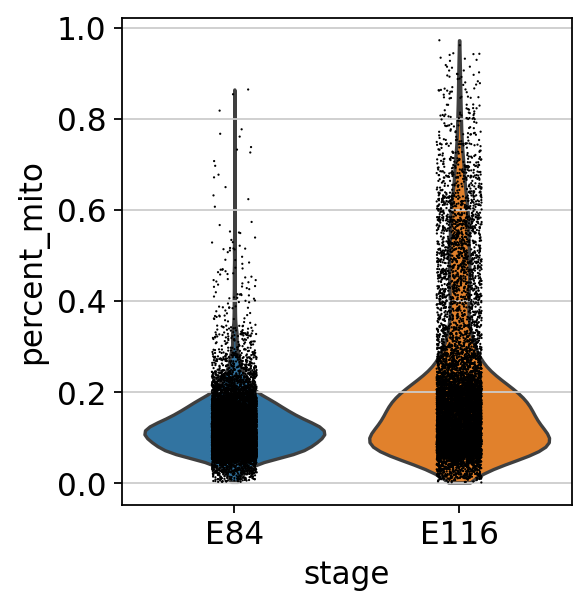

In [27]:
sc.pl.violin(adata, keys = ['percent_mito'], groupby = 'stage')

In [28]:
adata = adata[adata.obs.percent_mito < 0.2, :]
adata = adata[adata.obs.n_genes < 3000, :] # Match the author's thresholds

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [29]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['stage'].value_counts()

Total number of cells: 12353
Total number of genes: 15078


E84     7746
E116    4607
Name: stage, dtype: int64

#### Save raw data

In [30]:
# Not log transformed
adata.raw = adata.copy()

#### Normalize and log-transform

In [31]:
# Normalize per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log-transform the data 
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#### Filter HVGs and perform PCA on them

In [32]:
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
for col in ['highly_variable','means', 'dispersions', 'dispersions_norm']:
    adata.var[col] = bdata.var[col]
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Total number of cells: 12353
Total number of genes: 2738


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1056: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [33]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:848: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


#### Transfer PCA to the main data

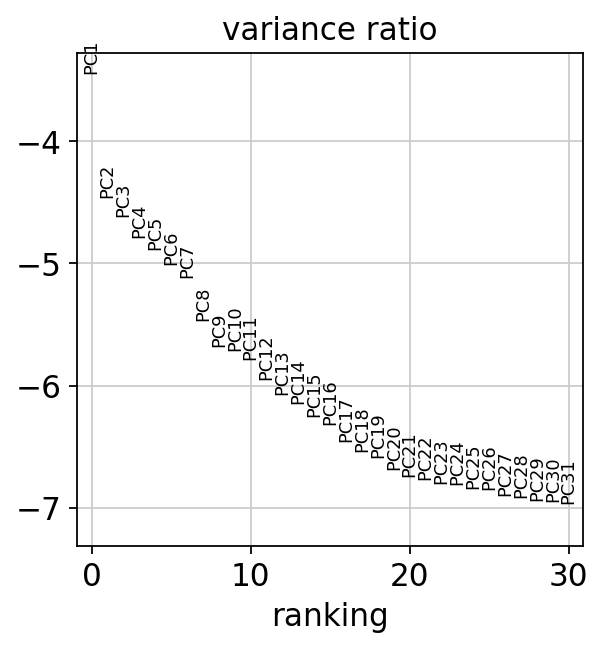

In [34]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

In [35]:
# Scale
sc.pp.scale(adata, max_value=10)

#### Regress out cell cycle genes

In [36]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, random_state = 123)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    581 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    660 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['S_score', 'G2M_score']


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1154: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'phase' as categorical


    finished (0:05:34)


#### Visualize data

In [37]:
n_pcs = 20
sc.pp.neighbors(adata, n_pcs = n_pcs, random_state=1)
# Visualize
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/home/jovyan/my-conda-envs/celloracle_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1154: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


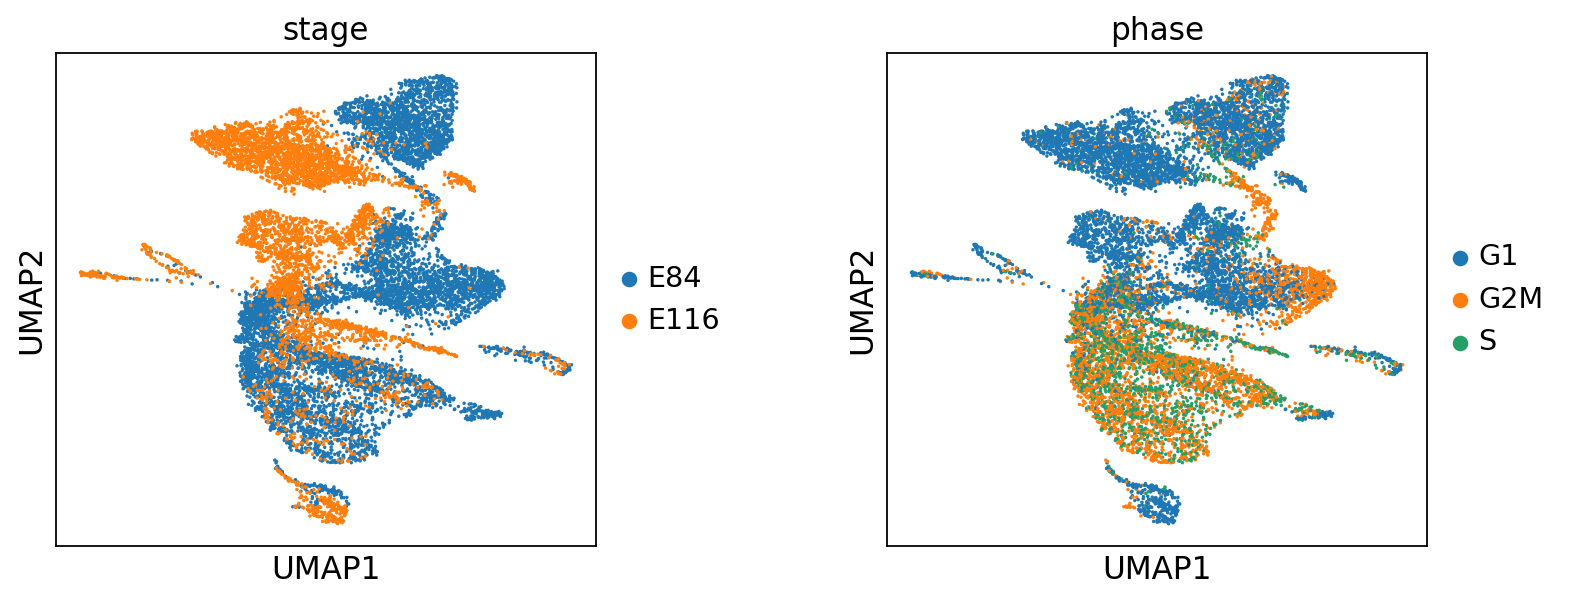

In [38]:
sc.pl.umap(adata, color=['stage', 'phase'],  ncols = 2, wspace = 0.4)

#### Save object

In [39]:
adata.write('/nfs/team292/vl6/Monkey_Zhao/preprocessing.h5ad')